# Arabic letters classification
## accuracy : 73.2 %
## traininig accuracy : 91 %
## Dataset : 
the training set containe 13440 image 
the test set containe 2760 image

the images are 32x32 with 3 channels 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! unzip './drive/My Drive/Dataset/arabic_train.zip' -d './arabic_train' > './zip_train.txt'

! unzip './drive/My Drive/Dataset/arabic_test.zip' -d './arabic_test' > './zip_test.txt'

In [3]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch.autograd import Variable

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
data_dir = './arabic_train'
torch.set_default_tensor_type('torch.cuda.FloatTensor')

transform = transforms.Compose([transforms.Resize(32),
                                transforms.CenterCrop(32),
                                transforms.ToTensor()])
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

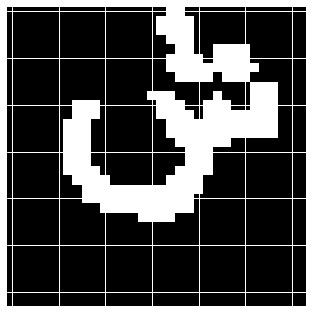

In [57]:
import Helper
images, labels = next(iter(dataloader))
Helper.imshow(images[10], normalize=False)

compute the Dataset mean and std for normalization

In [8]:
m1=0;m2=0;m3=0 # the mean for 3 channels 
s1=0;s2=0;s3=0 # std for 3 channels
for images , labels in dataloader :
  m1 += np.array(images[:,1,:,:]).mean()
  m2 += np.array(images[:,1,:,:]).mean()
  m3 += np.array(images[:,1,:,:]).mean()
  s1 += np.array(images[:,1,:,:]).std()
  s2 += np.array(images[:,1,:,:]).std()
  s3 += np.array(images[:,1,:,:]).std()
l=len(dataloader)
print([m1/l,m2/l,m3/l])
print([s1/l,s2/l,s3/l])

[0.10099044073195684, 0.10099044073195684, 0.10099044073195684]
[0.30120781447206224, 0.30120781447206224, 0.30120781447206224]


In [0]:
train_transforms = transforms.Compose([transforms.RandomRotation(5),
                                       transforms.Resize(32),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.1, 0.1, 0.1], std=[0.301, 0.301, 0.301]) ])

test_transforms = transforms.Compose([transforms.Resize(32),
                                      transforms.ToTensor(),
                                     transforms.Normalize([0.1, 0.1, 0.1], 
                                                            [0.301, 0.301, 0.301])])

In [0]:

train_data = datasets.ImageFolder('./arabic_train', transform=train_transforms)
test_data = datasets.ImageFolder('./arabic_test', transform=test_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


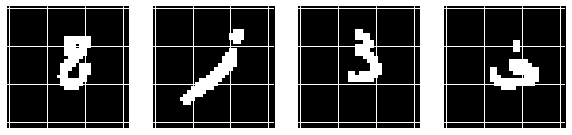

In [58]:
data_iter = iter(train_loader)
test_iter=iter(test_loader)
images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    Helper.imshow(images[ii], ax=ax, normalize=False)

the network contain 4 layers , the input layer and 2 hidden layers and the output layer

In [28]:
import torch.nn as nn
import math
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.classifier = nn.Sequential(
            nn.Linear(3*32 * 32, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(2048, 800),
            nn.BatchNorm1d(800),
            nn.ReLU(inplace=True),
            nn.Linear(800, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.15),
            nn.Linear(128, 28),
            nn.LogSoftmax(dim=1)


        )
        # xavier weight initalization

        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x 
model = Net()
model.cuda()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Net(
  (classifier): Sequential(
    (0): Linear(in_features=3072, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=2048, out_features=800, bias=True)
    (5): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): Linear(in_features=800, out_features=128, bias=True)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Dropout(p=0.15)
    (11): Linear(in_features=128, out_features=28, bias=True)
    (12): LogSoftmax()
  )
)

In [0]:

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-5) #1e-3 , 1e-5

criterion = nn.NLLLoss()
criterion.cuda()

In [30]:
train_loss=0 
epoch_accuracy=0
loss_train=[]
acc_train=[]
for epoch in range(1,150):
    train_loss=0
    epoch_accuracy = 0
    for x,y in train_loader :
        x,y = x.cuda(),y.cuda()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        pred = torch.exp(y_pred).data.max(1, keepdim=True)[1]
        epoch_accuracy += pred.eq(y.data.view_as(pred)).cpu().sum()
        
    if epoch % 2 == 0 :
        print("epoch :",epoch," loss : ",train_loss/len(train_loader.dataset), "acc :",epoch_accuracy.item()/len(train_loader.dataset))
    acc_train.append(100*epoch_accuracy.item()/len(train_loader.dataset))
    loss_train.append(train_loss)

epoch : 2  loss :  0.05022216579389004 acc : 0.48526785714285714
epoch : 4  loss :  0.03944382467528894 acc : 0.5859375
epoch : 6  loss :  0.03429245921738801 acc : 0.6362351190476191
epoch : 8  loss :  0.030966459223557088 acc : 0.6676339285714286
epoch : 10  loss :  0.028513184790721253 acc : 0.6945684523809523
epoch : 12  loss :  0.026178279916001926 acc : 0.7191964285714286
epoch : 14  loss :  0.024572506788674564 acc : 0.7364583333333333
epoch : 16  loss :  0.022978872823573294 acc : 0.7507440476190477
epoch : 18  loss :  0.021638560142101988 acc : 0.7663690476190477
epoch : 20  loss :  0.021049068446847653 acc : 0.7720982142857142
epoch : 22  loss :  0.019744874283094845 acc : 0.7810267857142857
epoch : 24  loss :  0.018811941376355078 acc : 0.7932291666666667
epoch : 26  loss :  0.01819250007559146 acc : 0.7974702380952381
epoch : 28  loss :  0.017777210605951648 acc : 0.805952380952381
epoch : 30  loss :  0.016612027883751407 acc : 0.8180059523809524
epoch : 32  loss :  0.01604

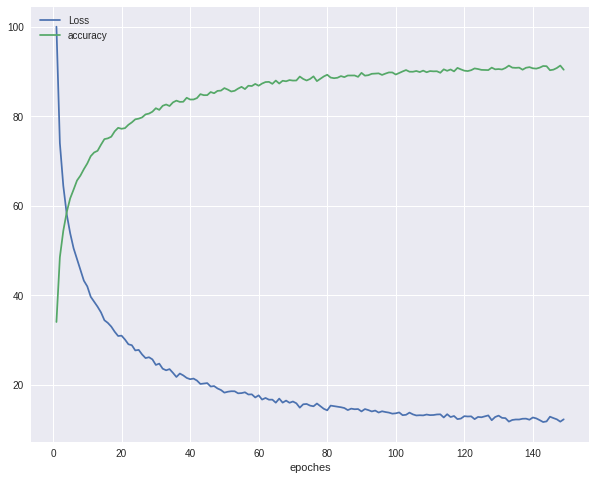

In [52]:
import seaborn as sns

t= np.array(loss_train).round(2)
a= np.array(acc_train).round(2)

t = 100* t/t.max()     # scalling the loss to be in [0,100], so i can plot it with the accuracy
x=np.array(range(1,150)) # the x axis

plt.figure(figsize=(10,8))
plt.style.use('seaborn')

plt.plot(x,t)
plt.xlabel('epoches')
plt.plot(x,a)
plt.legend(['Loss', 'accuracy'], loc='upper left')
plt.show()


In [73]:
correct=0
for x,y in test_loader :
  x,y = x.cuda(),y.cuda()
  out=model(x)
  pred = torch.exp(out).data.max(1, keepdim=True)[1]
  correct += pred.eq(y.data.view_as(pred)).cpu().sum().item()

print(correct/len(test_loader.dataset))


0.732360821673117
